# MPR121 Data Analysis Notebook
Author: Christopher Parker (parkecp@mail.uc.edu)

In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dict = {}
with h5py.File('raw_data_2025-04-07_15-46-51.h5', 'r') as h5f:
    for k,v in h5f.items():
        data_dict[k] = {}
        data_dict[k]['time_data'] = v['time_data'][()]
        data_dict[k]['cap_data'] = v['cap_data'][()]
        

In [3]:
# cap_data = np.concat((cap_data[:,:1000],cap_data[:,2000:]), axis=1)
# time_data = np.concat((time_data[:,:1000],time_data[:,2000:]), axis=1)

In [8]:
time_data = data_dict['sensor_1']['time_data']
cap_data = data_dict['sensor_1']['cap_data']

In [9]:
for idx, row in enumerate(time_data):
    time_data[idx,:] = row - row[0]

In [10]:
# Make sure the time reads are monotonically increasing, if this
# errors something has gone wrong while recording the data
assert np.all([time_data[0,x] < time_data[0,x+1] for x in range(1999)])

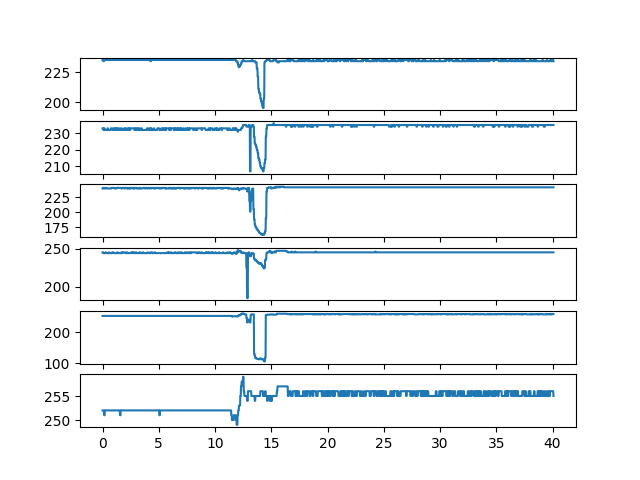

In [11]:
%matplotlib widget
fig, axes = plt.subplots(nrows=6)
for idx,ax in enumerate(axes):
    ax.plot(time_data[idx,:], cap_data[idx,:])

In [15]:
import scipy
b, a = scipy.signal.butter(4, [8, 12], btype='bandpass', fs=58)

In [20]:
filtered_data = scipy.signal.filtfilt(b, a, cap_data, axis=1)
for idx, sensor in enumerate(filtered_data):
    filtered_data[idx] = [0 if np.abs(x) < 5 else x for x in sensor]

In [21]:
filtered_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 7.44989155, 7.8175883 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(12, 422000))

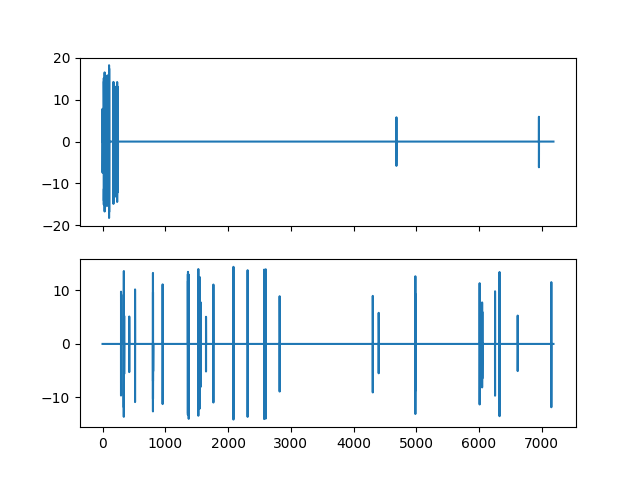

In [22]:
%matplotlib widget
fig, axes = plt.subplots(nrows=2, sharex=True)
for idx,ax in enumerate(axes):
    ax.plot(time_data[idx*2+1,:], filtered_data[idx*2+1,:])

In [23]:
time_data[0,-1]

np.float64(7185.953088283539)